# Homework 2 (66 pts)

## Overview
This homework will focus on checking the global and local spatial autocorrelation and point pattern analysis based on the Airbnb listing in New York City and the underlying socioeconomics. Through this practice, you will review the process of retrieving data from API, building spatial weights from georeferenced data, checking global and local spatial autocorrelation, and conducting point pattern analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

In [44]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import cenpy
from matplotlib import pyplot as plt

from pysal.lib import weights

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data (4 pts)
Homework 1 presented detailed steps of downloading and cleaning census tract data while here you can try Socrata to retrieve the same dataset. Use the following link: https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6 and find the API Endpoint. 
- Specify the BoroName as Manhattan in the url. (2 pts)
- Transform the downloaded dataframe into a geodataframe and set the crs as 4326. (2 pts)

Present the geodataframe (name it as **ct**).

In [13]:
#Read in data from API, filter by boroname
ct = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?boroname=Manhattan")
#Transform to geodataframe
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct,geometry='the_geom', crs = 4326)
ct

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495244,9.723122e+05
2,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,"MULTIPOLYGON (((-73.96128 40.73016, -73.96128 ...",62.00,1,Manhattan,6200,1006200,Murray Hill-Kips Bay,MN0603,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,36061006200,13027.679013,3.167925e+06
306,"MULTIPOLYGON (((-73.97817 40.74164, -73.97716 ...",66.00,1,Manhattan,6600,1006600,Murray Hill-Kips Bay,MN0603,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,36061006600,5498.146712,1.880521e+06
307,"MULTIPOLYGON (((-73.98407 40.74332, -73.98453 ...",56.00,1,Manhattan,5600,1005600,Midtown South-Flatiron-Union Square,MN0501,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,36061005600,5723.840529,1.878253e+06
308,"MULTIPOLYGON (((-73.98085 40.74775, -73.98134 ...",74.00,1,Manhattan,7400,1007400,Midtown South-Flatiron-Union Square,MN0501,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,36061007400,5726.157649,1.879420e+06


### 1.2 Read and Clean Airbnb Listing Data (2 pts)
Similar to homework 1, you are required to download and clean the Airbnb listing data and wrap all of them into one cell. Use the same link in homework 1 to download the listing data in New York City.
- Change *price* column type as float.
- Transform the dataframe into geodataframe using the latitude-longitude pairs.
- Spatial join **ct** with only *geoid*, *boroname* and *the_geom* columns to the listing geodataframe.

You should only have the listings in Manhattan. Present your geodataframe **listing** below.

In [26]:
listing_raw = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz")

/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_43138/683252828.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  listing_raw = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz")


In [27]:
#Remove unwanted symbols and change price column type to float
listing_raw['price'] = listing_raw['price'].str.replace("$","").str.replace(",","").astype(float)

#Convert to geodataframe
geometry = gpd.points_from_xy(listing_raw["longitude"], listing_raw["latitude"])
listings_g = gpd.GeoDataFrame(listing_raw, geometry = geometry, crs = 4326)



/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_43138/3295586121.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listing_raw['price'] = listing_raw['price'].str.replace("$","").str.replace(",","").astype(float)


0        POINT (-73.98559 40.75356)
1        POINT (-73.96751 40.80380)
2        POINT (-73.99454 40.66265)
3        POINT (-73.95512 40.68535)
4        POINT (-73.95342 40.70935)
                    ...            
41528    POINT (-73.90065 40.87094)
41529    POINT (-73.80467 40.69891)
41530    POINT (-73.96238 40.80259)
41531    POINT (-73.84789 40.82807)
41532    POINT (-73.99730 40.74003)
Name: geometry, Length: 41533, dtype: geometry

In [29]:
# enter your codes here
listing = gpd.tools.sjoin(listings_g, ct[['geoid', 'boroname', 'the_geom']], how = 'right')

listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17336 entries, 0 to 309
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   index_left                                    17333 non-null  float64 
 1   id                                            17333 non-null  float64 
 2   listing_url                                   17333 non-null  object  
 3   scrape_id                                     17333 non-null  float64 
 4   last_scraped                                  17333 non-null  object  
 5   source                                        17333 non-null  object  
 6   name                                          17325 non-null  object  
 7   description                                   17054 non-null  object  
 8   neighborhood_overview                         9538 non-null   object  
 9   picture_url                                 

### 1.3 Retrieve American Community Survey (ACS) Data (6 pts)
The 3rd dataset is from American Community Survey. You can first check with "2019 ACS Table List" from [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) and find the median household income code as **B19013_001**. Use *cenpy* module to download the household income information in New York City and use census tract level as the geographic unit. Save the data as **acs_data** and name the column for household income as *median_hh_inc*. Present the information of **acs_data**. (2 pts)

In [31]:
# Establish connection and extract data
acs_cp= cenpy.products.ACS()
acs_data = acs_cp.from_place('New York, NY',
                                level='tract',
                                variables=['B19013_001'])

In [35]:
# Change column name
acs_data = acs_data.rename(columns = {'B19013_001E': 'median_hh_inc'})
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2006 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


Notice that *median_hh_inc* column includes null values. Replace all null values with the mean of the median household income. (2 pts)

In [39]:
# enter your codes here
acs_data['median_hh_inc'] = acs_data['median_hh_inc'].fillna(np.mean(acs_data['median_hh_inc']))

Plot the median household income by census tract. Five quantiles are used here with *GnBu* color ramp. Remember to add:
- Title
- Legend
- X-Y axis names

properly to the map. (2 pts)

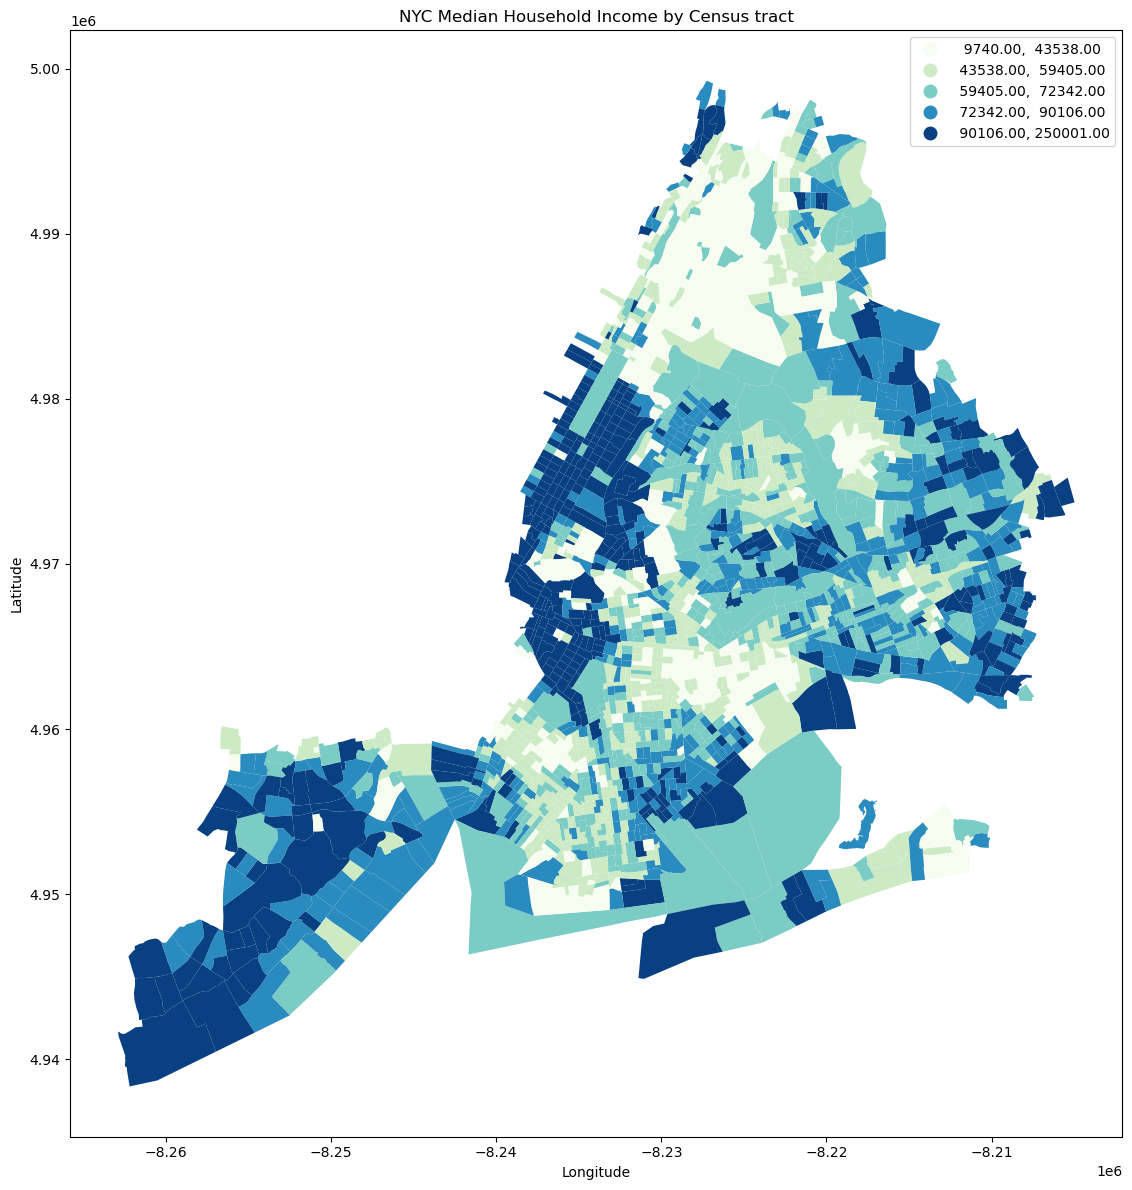

In [42]:
# enter your codes here
fig, ax = plt.subplots(figsize=(12,12))
plt.title("NYC Median Household Income by Census tract")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

acs_data.plot(column='median_hh_inc',
                ax = ax,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True)


## Use tight_layout to remove the white space around the plot
plt.tight_layout()

## 2. Data Analysis & Visualization
### 2.1 Create Spatial Weights (12 pts)
ACS data is firstly analyzed. Create a spatial weight, *wq*, with *Queen* method and standardize the spatial weight. (2 pts)

In [46]:
# enter your codes here
wq = weights.contiguity.Queen.from_dataframe(acs_data)
wq.transform = "R"

('WARNING: ', 229, ' is an island (no neighbors)')


/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 229.
  warnings.warn(message)


Since *median_hh_inc* column will be used repetitively, store this column in variable *y*. Therefore, *ylag* is generated from *y* to store the spatial lags of *median_hh_inc*. (2 pts)

In [48]:
# enter your codes here
y = acs_data['median_hh_inc']
ylag = weights.spatial_lag.lag_spatial(wq, y)

#add spatial lag to dataframe
acs_data['med_inc_lag'] = ylag

To compare *y* with *ylag* visually, you can create two plots side by side. 
- Both maps should have 5 quantiles of *y* and *ylag* respectively with your choice of color ramp. (2 pts)
- Both maps should have proper titles and legends. (2 pts)
- Remove axis for both maps. (2 pts)

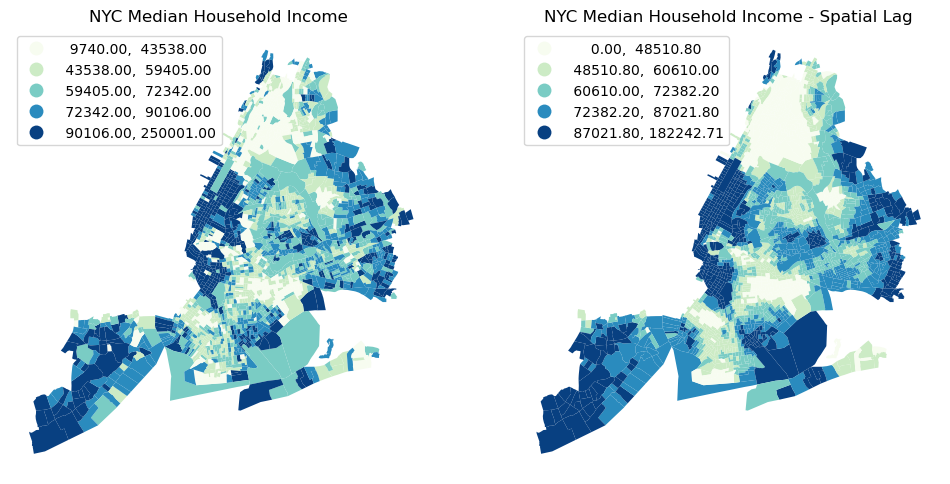

In [52]:
# enter your codes here
f, axs = plt.subplots(1, 2, figsize=(12, 12))
ax1, ax2 = axs

acs_data.plot(column='median_hh_inc',
                ax = ax1,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True,
                legend_kwds={'loc': 'upper left'})
ax1.set_axis_off()
ax1.set_title("NYC Median Household Income ")


acs_data.plot(column='med_inc_lag',
                ax = ax2,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True,
                legend_kwds={'loc': 'upper left'})
ax2.set_axis_off()
ax2.set_title("NYC Median Household Income - Spatial Lag")


plt.show()

Why do the two maps look different? How do you interpret the difference? (2 pts)

### 2.2 Global Spatial Correlation (8 pts)
By plotting median household income above, you will have some ideas about where the affluent and the less affluent people live. To verify your hypothesis, you can try to find how they are correlated with their neighbors globally.

Firstly, create a boolean list *yb* if the census tract's median household income (*y*) exceeds the median median household income in Manhattan (median of *y*). (2 pts)

In [57]:
# enter your codes here
yb = y > np.median(y)

In [ ]:
# enter your codes here

Next, create a new column *yb* in **acs_data** where *0 low* means the census tract's median household income is below the median of *y* and *1 high* means the rest. (2 pts)

In [59]:
# enter your codes here
acs_data['yb'] = (y > np.median(y)).astype(int)

Plot census tracts whose household income are above the median as black and those below as white. (2 pts)

<AxesSubplot: >

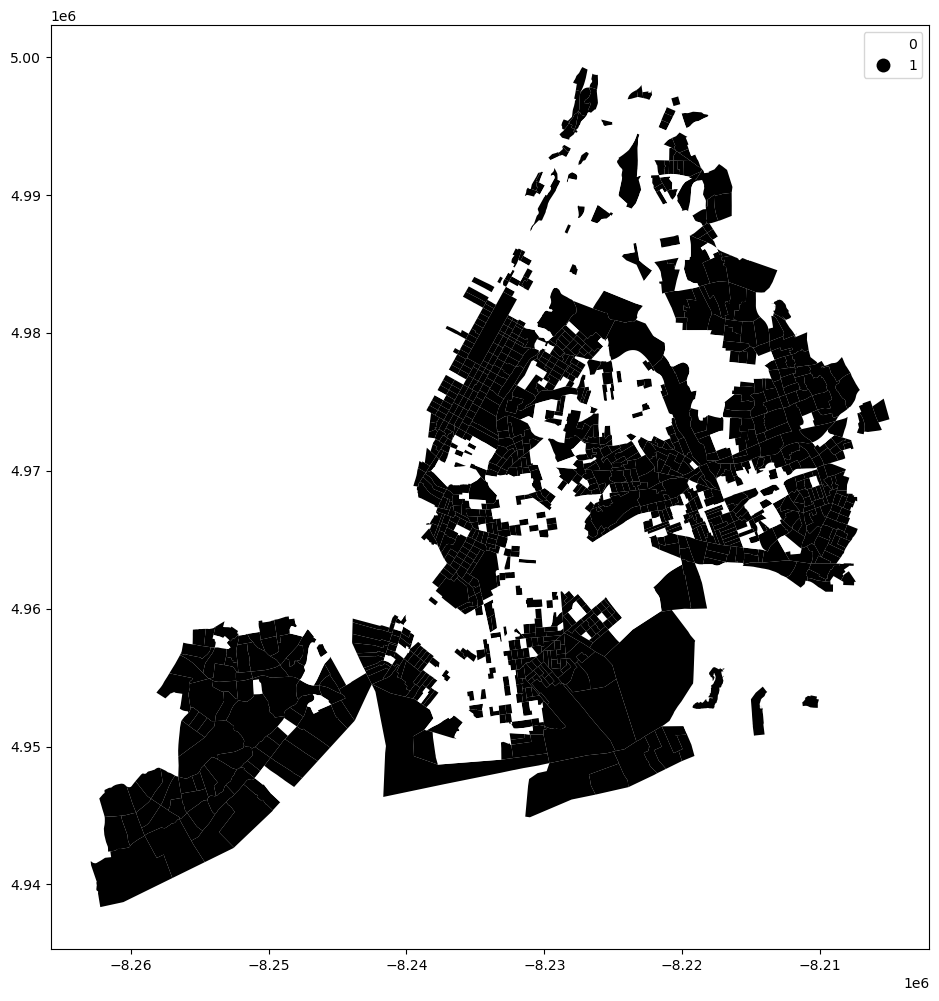

In [63]:
# enter your codes here
fig, ax = plt.subplots(figsize=(12,12))

acs_data.plot(column='yb',
                categorical = True,
                ax = ax,
                cmap='binary',
                legend=True)
                

Do you think a binary map is better at showing spatial disparity than the quantile map in Q2.1? (2 pts)

### 2.3 Moran's I (8 pts)
By looking at the maps, you are convinced that wealth is not distributed across NYC space evenly. Moran's I will provide you a statistical tool to further testify your hypothesis. 

To create a Moran Plot, you should first calculate the difference between the median household income and its mean. Then repeat the step for the spatial lags of the median household income. Add these two lists to **acs_data** as column *y_std* and *ylag_std*. (2 pts)
Then use seaborn module to make a scatter plot using the two columns. Add x and y axis names and tiles to the plot. (2 pts)

In [ ]:
# enter your codes here

How do you interpret the Moran's Plot? Does it indicate a strong or weak autocorrelation? (2 pts)

What is the value of your Moran's I? (2 pts)

In [ ]:
# enter your codes here

### 2.4 Local Spatial Autocorrelation (8 pts)
The significant value of Moran's I confirms that the spatial distribution of NYC's wealth is highly uneven. But where are the richest neighborhoods and where are the poorest?

Firstly you can generate local Moran's I and name this variable as *li*. (2 pts)

In [ ]:
# enter your codes here

Based on the significance value (less than 0.05), create a new column *cl* to **acs_data** with values of *0 ns*, *1 hot pot*, *2 doughnut*, *3 cold spot*, and *4 diamond*. (2 pts)
As the names indicate, Hot Spot is the neighborhoods with high household income and Cold Spot is the neighborhoods with low household income. Doughnut is the low-income neighborhoods surrounded by high-income neighbors while Diamond is the high-income neighborhoods surrounded by low-income neighbors.

In [ ]:
# enter your codes here

In [ ]:
# enter your codes here

Plot the four types of census tracts with lightgrey to *0 ns*, red to *1 hot pot*, lightblue to *2 doughnut*, blue to *3 cold spot*, and pink to *4 diamond*. Add legend and titles to the plot. (2 pts)

In [ ]:
# enter your codes here

How do you interpret the four types of colored regions under the NYC context? Why do some parks apprear as "doughnuts"? (2 pts)

### 2.5 Point Pattern Analysis (18 pts)
With an image of wealth distribution across NYC, now you can move to the Airbnb listing to see if locations of the short-term rental listing have any relationship with their neighborhoods.

Map all the listing in Manhattan by their coordinates and show the density on latitudes and longitudes respectively. (2 pts)

In [ ]:
# enter your codes here

To generate a density map for points data, you should firstly assign those points to different areal units. Hexagon is one of the most used units. For Manhattan, you can generate and add hexbin with 50 hexagons in each dimension without bordorline and with half transparency. (2 pts) Add a base map and colorbar and remove axes. (2 pts) Show your map below.

In [ ]:
# enter your codes here

Find out the mean center (2 pts), median center (2 pts) and standardized ellipse of the Manhattan Airbnb listing. Legend and axis names should be added.

In [ ]:
# enter your codes here

Why do the mean and median centers differ? (2 pts)

Generate a quadrat count map based on the listing. In each quadrat, the number of listings should be shown. (2 pts)

In [ ]:
# enter your codes here

From the Quadrat Count figure, which areas have the densest Airbnbs? Provide some hypotheses for why this might be the case. (2 pts)

What is the p-value of a chi-squared test? How do you interpret the value? (2 pts)

In [ ]:
# enter your codes here